## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from variaIa import baserate
from variaIa import stretchevol
from scipy.stats import poisson
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
from numpy.random import randint as rdint
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../../../../Data/sne/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../../../Data/sne/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNLS')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    if su == 'SNLS':
        dataz = np.sort(surv[su].zCMB.values)
        # [np.where(surv[su].zCMB.values > .4)]
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=3, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ baserate

## Calcul pour l'échantillon choisi

{'a': 2.5601125716644977, 'a.err': 0.141792853928297, 'chi2': 325.4995008043588}


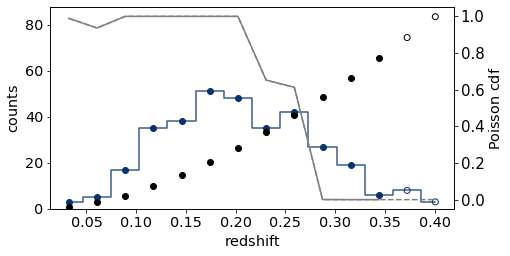

In [53]:
fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

base_r = baserate.VolumeNoModel()
rate_r = baserate.RateFitter()

if su.value == 'SNLS':
    # define start of histogram randomly between 0.06 and 0.12
    data_r_a = rdint(math.floor(dataz[0]*100)/2,
                     math.floor(dataz[0]*100))/100
    # define end of histogram randomly between 1.10 and 1.15
    data_r_b = rdint(math.ceil(dataz[-1]*10)*10,
                     (math.ceil(dataz[-1]*10)
                      + math.floor(dataz[0]*10)/2)*10)/100
else:
    data_r_a = rdint(math.floor(dataz[0]*1000)/2,
                     math.floor(dataz[0]*1000))/1000
    data_r_b = rdint(math.ceil(dataz[-1]*100)*10,
                     (math.ceil(dataz[-1]*100)
                      + math.floor(dataz[0]*100)/2)*10)/1000

# complete random data is start + normal data + end
data_r = np.append(data_r_a, np.append(dataz, data_r_b))
# define total number of bins
nb_bins_r = rdint(5, 20)
# nb_bins_r = 10

counts_r, bord_r = np.asarray(np.histogram(data_r, bins=nb_bins_r))

bins_r = np.asarray([[bord_r[i], bord_r[i+1]]
                    for i in range(len(bord_r)-1)]).T

rate_r.set_data(counts_r, bins_r)
rate_r.set_model(base_r)

rate_r.set_fitted_flag(rate_r._central_redshiftranges
                       < rate_r._central_redshiftranges
                       #[7])
                       [np.random.randint(3, nb_bins_r)])
rate_r.fit(True, a_guess=0.2)

rate_r.show(ax=ax, datacolor=colors[su.value], stepalpha=0.8, modelcolor='k')

# ax.set_xlim([0, 1.2])
# ax.set_ylim([0, 90])

print(rate_r.get_fitvalues())

fig.savefig('../../../../Images/Archives/zmax_method_snls-02.pdf', bbox_inches='tight')

itsc = {'SDSS': [.9, .5, .05],
        'PS1': [.9, .5, .05],
        'SNLS': [.65, .5, .22]}
guess = .2
loops = 100

res_one = {su.value: baserate.zmax_poisson(su.value, dataz, guess, loops, itsc)}
# res_all = {survey: baserate.zmax_poisson(survey, dataz, guess, loops, itsc)
#           for survey in su.options[1:-1]}

## Tracé pour l'échantillon choisi

z_lin = {su.value: res_one[su.value][0]}
med = {su.value: res_one[su.value][1]}
std = {su.value: res_one[su.value][2]}
maxx = {su.value: res_one[su.value][3]}

baserate.zmax_pshow(z_lin, med, std, maxx, itsc, True, True)

## Tracé pour l'échantillon choisi depuis données sauvegardées

with open('../../../../Data/zmax/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

z_lins_one = {su.value: z_lins[su.value]}
meds_one = {su.value: meds[su.value]}
stds_one = {su.value: stds[su.value]}
z_max_one = {su.value: z_max[su.value]}

baserate.zmax_pshow(z_lins_one, meds_one, stds_one, z_max_one,
                    itsc, True, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/zmax_' + str(su.value) +
#'_095_stds_point.pdf', bbox_inches='tight')

## Tracé des trois échantillons

### Dictionnaires des z_intp, meds, stds et z_max ± inf/sup

res = dict()
meds = dict()
stds = dict()
z_lins = dict()
z_max = dict()

itsc = {'SDSS': [.85, .5, .05],
        'PS1': [.9, .5, .05],
        'SNLS': [.65, .5, .25]}
guess = .2
loops = 1000

for survey in surveys[1:-1]:
    res[survey] = baserate.zmax_poisson(survey,
                                        np.sort(surv[survey].zCMB.values),
                                        guess, loops, itsc)
    z_lins[survey] = res[survey][0]
    meds[survey] = res[survey][1]
    stds[survey] = res[survey][2]
    z_max[survey] = res[survey][3]

### Résultats et sauvegarde

z_max

#### Attention en m'écrasant !

with open('../Data/zmax_null_result', 'wb') as f:
    pickle.dump([z_lins, meds, stds, z_max, itsc], f)

### Tracé effectif

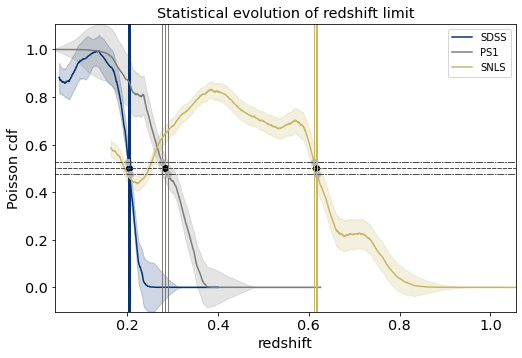

In [6]:
with open('../../../../Data/zmax/zmax_095_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

baserate.zmax_pshow(z_lins, meds, stds, z_max, itsc, True, True)

fig=plt.gcf()
fig.savefig('../../../../Images/Archives/zmax_all_095_stds_points-cividis.pdf',
            bbox_inches='tight')

In [11]:
z_max_pm = {survey: [z_max[survey][-1]-z_max[survey][1], z_max[survey][1]-z_max[survey][0]]
           for survey in z_max.keys()}

In [13]:
z_max

{'SDSS': array([0.203 , 0.2043, 0.2055]),
 'PS1': array([0.2763, 0.284 , 0.29  ]),
 'SNLS': array([0.6122, 0.6155, 0.619 ])}

In [14]:
z_max_pm

{'SDSS': [0.0011999999999999789, 0.0012999999999999956],
 'PS1': [0.006000000000000005, 0.007699999999999985],
 'SNLS': [0.0034999999999999476, 0.0033000000000000806]}

# Détermination des $z_{\text{max}}$ _via_ ratefit